In [25]:
# import the necessary libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline 
%config InlineBackend.figure_format = 'retina'
plt.style.use("ggplot")

import statsmodels.api as sm
import scipy.stats as scs


from scipy.stats import norm

In [2]:
#upload the dataset
data = pd.read_csv("https://github.com/muluwork-shegaw/10Acad_week4/blob/master/ABAdRecall.csv?raw=true",error_bad_lines=False)

### Exploring the dataset

In [ ]:
data.head() # glance  our dataset

In [ ]:
data.describe() #description of the dataset

In [ ]:
print('This dataset has '+str(data.shape[0])+' rows, and '
                         +str(data.shape[1])+ ' columns')


This dataset has 8077 rows, and 9 columns


In [ ]:
data.info() #summery
# This shows us the different data types and number of non-null values in
#each columns

 **NB :**
- As we can show in the summery ,we have totally 8077 data and there is no null values.

In [ ]:
data.nunique().sort_values(ascending=False) # number of unique  values in each vriable

In [3]:
sample_data = data[np.logical_or(data['yes']==1,data['no']==1)]
sample_data.shape # the data which contain who has  animpression to answer for 

(1243, 9)

 **NB :**
- the data which contain who has an impression to answer for BIO questionarie and they actually reply as "yes" or "no"

### Overview

In [4]:
# plot multiple his in one graph
def multple_hist(data,bins,legend,color):
    for i in range(len(data)):
        plt.hist(data[i], bins, color=color[i], alpha=0.5)
        plt.legend(legend)
    plt.show()

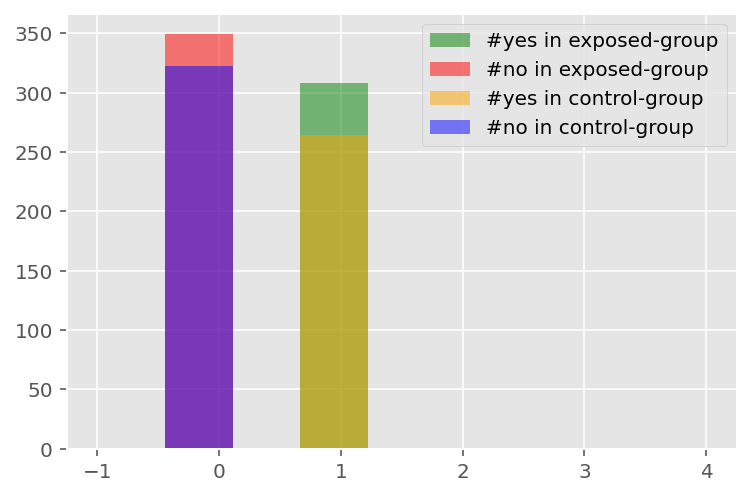

In [6]:
this_data = sample_data[['experiment','yes','no']]
exposed = this_data[this_data["experiment"] == "exposed"]
control = this_data[this_data["experiment"] == "control"]

datas = [exposed[exposed['yes']==1]['yes'],exposed[exposed['yes']==0]['yes'],
         control[control['yes']==1]['yes'],control[control['yes']==0]['yes']]

legend = ["#yes in exposed-group","#no in exposed-group",
          "#yes in control-group","#no in control-group"]
bins = np.linspace(-1, 4, 10)
color=["green","red","orange","blue"]

multple_hist(datas,bins,legend,color)

**NB:**
- The above figure shows us the distribution of the answers of the BIO(brand impact optimizer) for the users who are under the exposed and control group. 

- when we see histogram the count of yes is less than count no, which means most users don't know the brand smartAd.

**But when we compare the count of #yes in exposed and in control group ,the exposed group more know the brand smartAd than control group.** 
- #yes in exposed group is between  300 and 350
- #yes in control group is between  250 and 300


## Task 2: Analysis 
#### Task 2.1 : Classic and sequential A/B testing analysis


- Perform hypothesis testing: apply the classical p-value based algorithm and the  sequential A/B testing algorithm for which a starter code is provided..

Before running the test, we will know the baseline conversion rate and the desired lift or increase in awraeness of the brand that we would like to test.
- The baseline conversion rate is the current rate at which they answer "yes" under the existing design. 
- For our example, we want to use our test to confirm that the changes they make to the advertisment  will result in at least a 2% increase in awareness rate.

In [7]:
ab_summary = sample_data.pivot_table(values='yes', index='experiment', aggfunc=np.sum)
# add additional columns to the pivot table
ab_summary['total_ans'] = sample_data.pivot_table(values='yes', index='experiment', aggfunc=lambda x: len(x))
ab_summary['conversion_rate'] = sample_data.pivot_table(values='yes', index='experiment')

In [8]:
ab_summary

,yes,total_ans,conversion_rate
experiment,,,
control,264,586,0.450512
exposed,308,657,0.468798


In [9]:
ctrl_c = ab_summary['yes'][0]
ctrl_total = ab_summary['total_ans'][0]
ctrl_cr = ab_summary['conversion_rate'][0]

exp_c = ab_summary['yes'][1]
exp_total = ab_summary['total_ans'][1]
exp_cr = ab_summary['conversion_rate'][1]

d_cr = exp_cr-ctrl_cr
d_cr

0.018285619295484168

It looks like the difference in conversion rates between the two groups is 0.018 which is less than the lift we initially wanted of 0.02. This is not a good sign and this is not enough evidence for us to confidently go with the existing one. At this point we have not measured how confident we are in this result. This can be mitigated by looking at the distributions of the two groups.

###  Compare the Two Groups
We can compare the two groups by plotting the distribution of the control group and calculating the probability of getting the result from our test group. We can assume that the distribution for our control group is binomial because the data is a series of Bernoulli trials, where each trial only has two possible outcomes (similar to a coin flip).

Text(0, 0.5, 'probability')

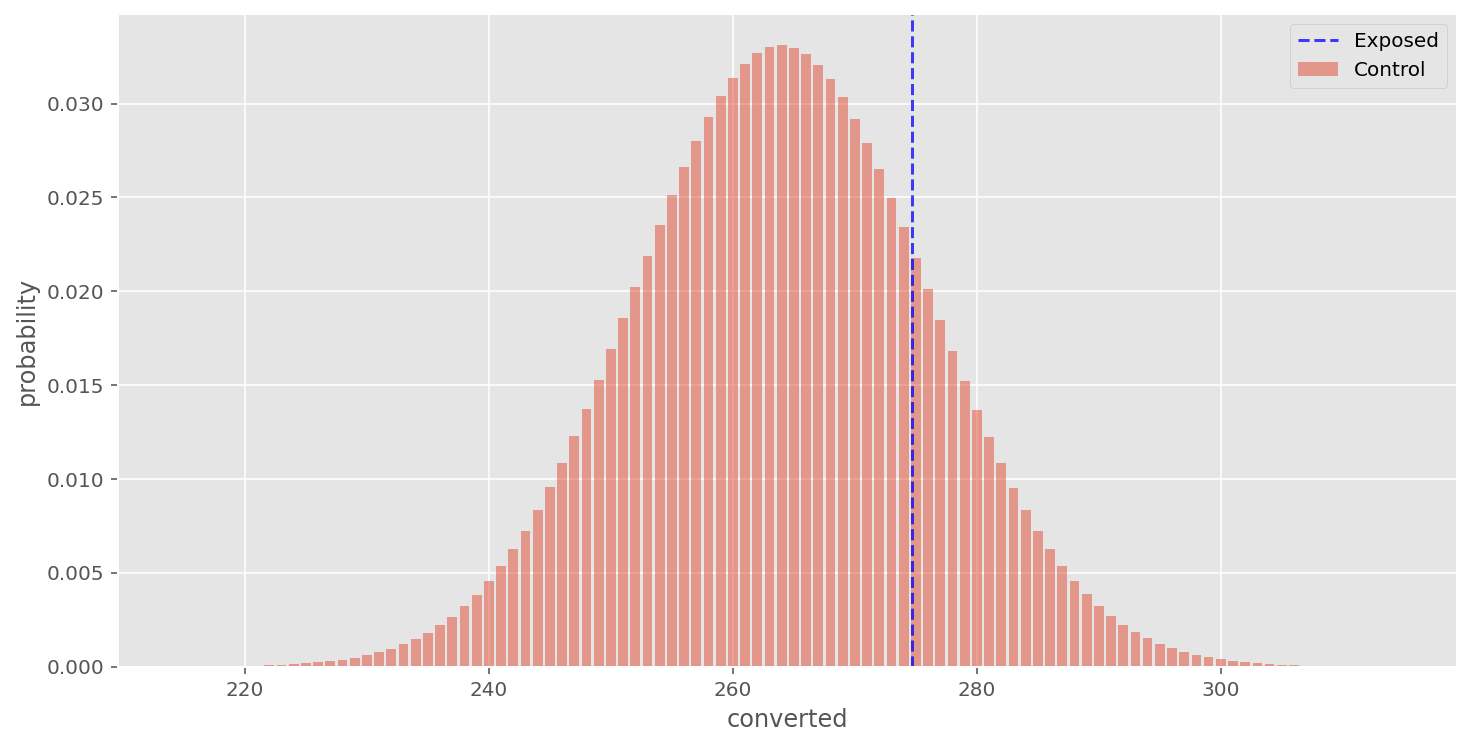

In [11]:
fig, ax = plt.subplots(figsize=(12,6))

x = np.linspace(ctrl_c-49, ctrl_c+50, 100)
y = scs.binom(ctrl_total, ctrl_cr).pmf(x)

ax.bar(x, y,label="Control", alpha=0.5)
ax.axvline(x=exp_cr * ctrl_total, c='blue',label ="Exposed", alpha=0.75, linestyle='--')

plt.legend()
plt.xlabel('converted')
plt.ylabel('probability')

The distribution for the control group is shown in red and the result from the test group is indicated by the blue dashed line. We can see that the probability of getting the result from the test group was very low. However, the probability does not convey the confidence level of the results. It does not take the sample size of our test group into consideration. Intuitively, we would feel more confident in our results as our sample sizes grow larger. Let’s continue and plot the test group results as a binomial distribution and compare the distributions against each other.

### Binomial Distribution


Text(0, 0.5, 'probability')

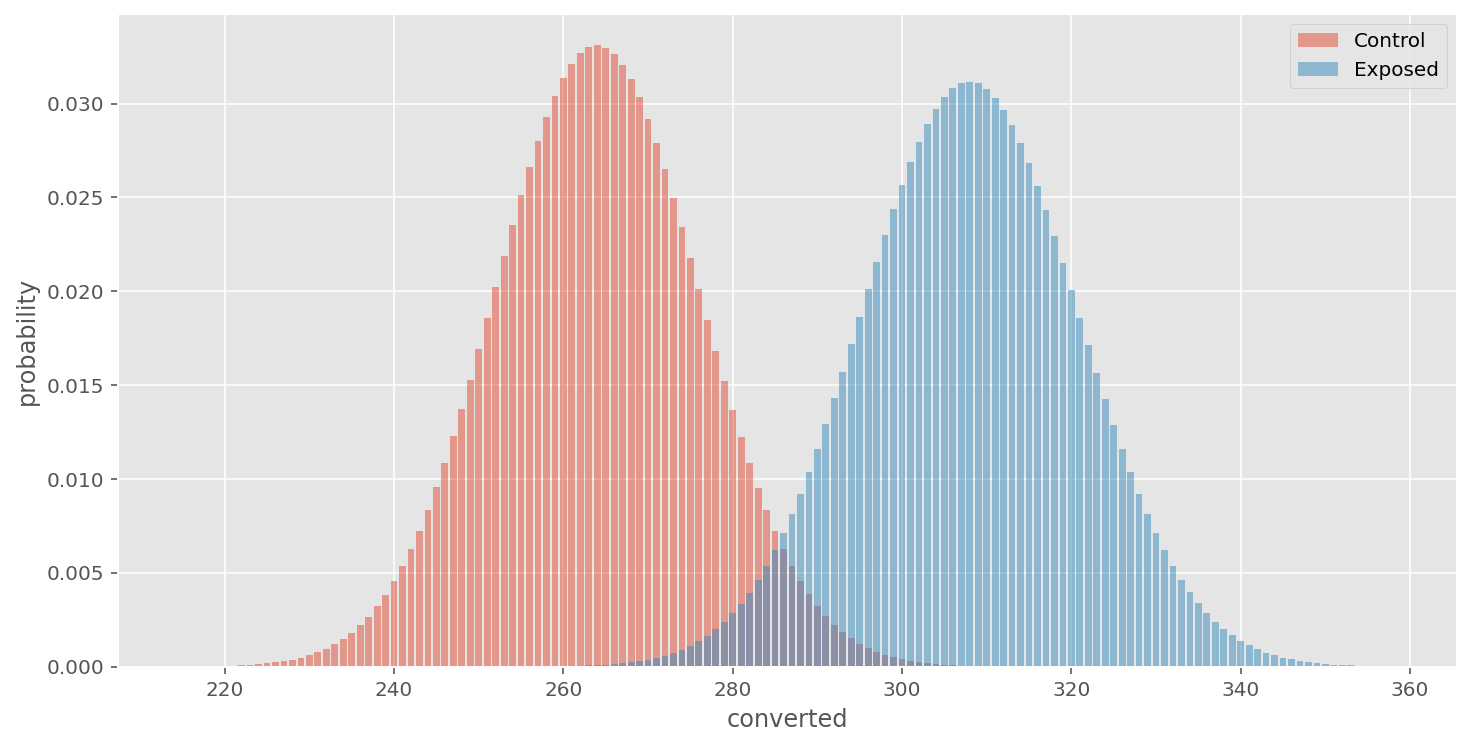

In [13]:
fig, ax = plt.subplots(figsize=(12,6))

xC = np.linspace(ctrl_c-49, ctrl_c+50, 100)
yC = scs.binom(ctrl_total, ctrl_cr).pmf(xC)
ax.bar(xC, yC, label = "Control",alpha=0.5)

xE = np.linspace(exp_c-49, exp_c+50, 100)
yE = scs.binom(exp_total, exp_cr).pmf(xE)
ax.bar(xE, yE, label = "Exposed",alpha=0.5)
plt.legend()
plt.xlabel('converted')
plt.ylabel('probability')

### Bernoulli Distribution and the Central Limit Theorem


Text(0, 0.5, 'probablity')

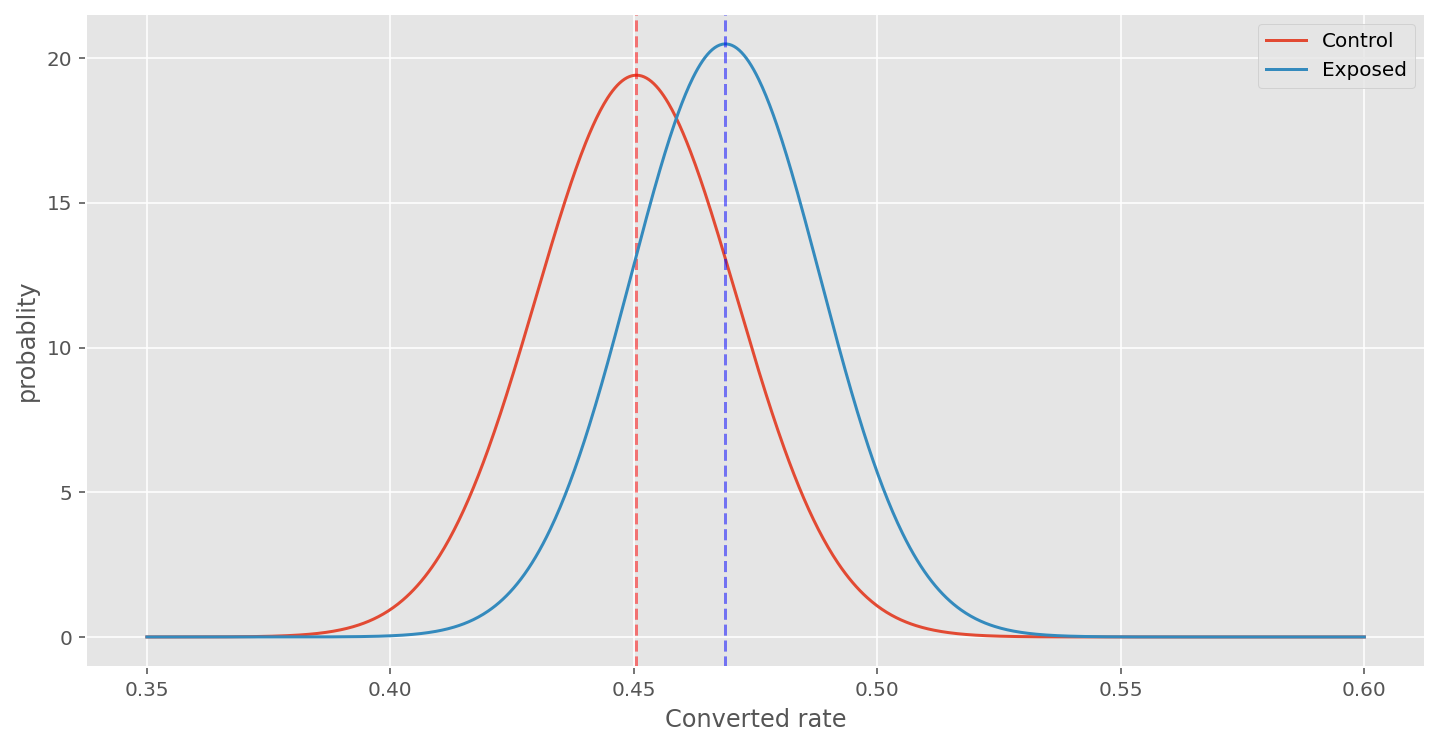

In [14]:
# standard error of the mean for both groups
std_C = np.sqrt(ctrl_cr * (1-ctrl_cr)) / np.sqrt(ctrl_total)
std_E = np.sqrt(exp_cr * (1-exp_cr)) / np.sqrt(exp_total)

# plot the null and alternative hypothesis
fig, ax = plt.subplots(figsize=(12,6))
x = np.linspace(.35, .6, 1000)

yC = scs.norm(ctrl_cr, std_C).pdf(x)
ax.plot(x, yC,label = "Control")
ax.axvline(x=ctrl_cr, c='red', alpha=0.5, linestyle='--')

yE = scs.norm(exp_cr, std_E).pdf(x)
ax.plot(x, yE,label = "Exposed")
ax.axvline(x=exp_cr, c='blue', alpha=0.5, linestyle='--')

plt.legend()
plt.xlabel('Converted rate')
plt.ylabel('probablity')

The dashed lines represent the mean conversion rate for each group. The distance between the red dashed line and the blue dashed line is equal to mean difference between the control and test group. d_cr is the distribution of the difference between random variables from the two groups.

- dcr = exp_cr - ctrl_cr 

### Compare the Null Hypothesis vs. the Alternative Hypothesis
- The null hypothesis is the position that the change in the design made for the test group would result in no change in the conversion rate.
- The alternative hypothesis is the opposing position that the change in the design for the test group would result in an improvement (or reduction) in the conversion rate.


the null hypothesis will be a normal distribution with a mean of zero and a standard deviation equal to the pooled standard error.

**Parameter of Interest**: p1 - p2, where p1 = control group and p2 = exposed group  

**Null Hypothesis, Ho:**   p1 - p2 = 0  
**Alternative Hypthosis, Ha:**  p1 - p2 $\neq$ 0  

**Data**:  from 657 users of exposed group. 46.88% has been show the brand ad with smartAd new creative. 
<br>from 586 users of control group. 45.05% has been show the brand ad with out the smartAd or with the existing system.

- the null hypothesis will be a normal distribution with a mean of zero and a standard deviation equal to the pooled standard error.

      Ho : mean_d = 0

      do ~ Normal(0,SE)

- The alternative hypothesis has the same standard deviation as the null hypothesis, but the mean will be located at the difference in the conversion rate, d_cr. This makes sense because we can calculate the difference in the conversion rates directly from the data, but the normal distribution represents the possible values our experiment could have given us.

      Ha : mean_d = pE - pC (exp_cr - ctrl_cr)
      da ~ Normal(d,SE)

- Now that we understand the derivation of the pooled standard error, we can just directly plot the null and alternative hypotheses for future experiments.

zscore is 0.646, with p-value 0.259


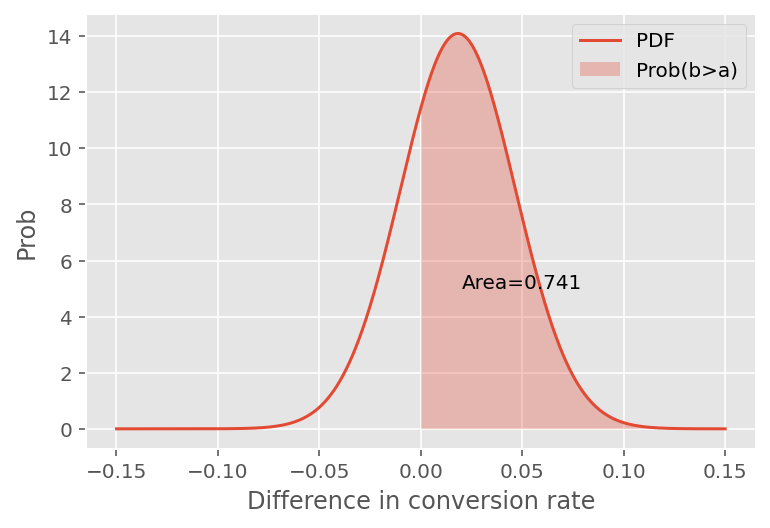

In [15]:
z_score = (d_cr) / np.sqrt(std_C**2 + std_E**2)
p = norm(d_cr, np.sqrt(std_C**2 + std_E**2))

x = np.linspace(-0.15, 0.15, 1000)
y = p.pdf(x)
area_under_curve = p.sf(0)
plt.plot(x, y, label="PDF")
plt.fill_between(x, 0, y, where=x>0, label="Prob(b>a)", alpha=0.3)
plt.annotate(f"Area={area_under_curve:0.3f}", (0.02, 5))
plt.legend()
plt.xlabel("Difference in conversion rate"); plt.ylabel("Prob");

print(f"zscore is {z_score:0.3f}, with p-value {norm().sf(z_score):0.3f}")

Using our classical approach so far, we would say that given the null hypothesis is true (tha impact of exposed is less then or equal to control), we would expect to get this result or a result more extreme 25.9% of the time. As that is a significant result (typically p > 5%), we fail to reject the null hypothesis, and state that we have weak evidence that Exposed  > Control.

We should explicitly note here that this is a one-tailed test - the question we’ve asked is if Exposed  > Control. An alterative is the two-tailed test, where we just want to discriminate that B is different to A. In that case, our p-value is actually 2 × 25.9 = 51.8  percent (as we have two tails, not one), and we would want more samples before rejecting the null hypothesis if we stick to the p-value of 0.05 threshold.



In [16]:
def get_confidence_ab_test(a_c, num_a, b_c, num_b):
    a_cr = a_c / num_a
    b_cr = b_c / num_b
    std_a = np.sqrt(a_cr * (1 - a_cr) / num_a)
    std_b = np.sqrt(b_cr * (1 - b_cr) / num_b)
    z_score = (b_cr - a_cr) / np.sqrt(std_a**2 + std_b**2)
    return norm.cdf(z_score)

print(get_confidence_ab_test(ctrl_c, ctrl_total, exp_c, exp_total))

0.7408273254172715


In [17]:
def get_p_value(a_c, num_a, b_c, num_b):
    a_cr = a_c / num_a
    b_cr = b_c / num_b
    std_a = np.sqrt(a_cr * (1 - a_cr) / num_a)
    std_b = np.sqrt(b_cr * (1 - b_cr) / num_b)
    z_score = (b_cr - a_cr) / np.sqrt(std_a**2 + std_b**2)
    return norm.sf(z_score)

print(get_p_value(ctrl_c, ctrl_total, exp_c, exp_total))

0.2591726745827285


In [18]:
# Draw 10000 samples of possible rates for a and b
n = 10000
rates_a = norm(ctrl_cr, std_C).rvs(n)
rates_b = norm(exp_cr, std_E).rvs(n)
b_better = (rates_b > rates_a).sum() / n
print(f"exposed is better than control {b_better * 100:0.1f}% of the time")

exposed is better than control 74.8% of the time


Which, rephrased to the language of before, is that Exposed = control 26.7% of the time, which is not statistically significant such that we fail to reject our hypothesis (that p1 = p2).



In [26]:
a_dist = np.zeros(ctrl_total)
a_dist[:ctrl_c] = 1
b_dist = np.zeros(exp_total)
b_dist[:exp_c] = 1
zscore, prob = scs.ttest_ind(a_dist, b_dist, equal_var=True)
print(f"Zscore is {zscore:0.2f}, p-value is {prob:0.3f} (two tailed), {prob/2:0.3f} (one tailed)")

Zscore is -0.65, p-value is 0.519 (two tailed), 0.259 (one tailed)


In [27]:
sm.stats.ztest(b_dist,a_dist,alternative="larger")

(0.6452687398426953, 0.2593765234051756)

In [31]:
def min_sample_size(ctrl_cr, d_cr, power=0.8, sig_level=0.05):
    """Returns the minimum sample size to set up a split test
    Arguments:
        ctrl_cr (float): probability of success for control, sometimes
        referred to as baseline conversion rate
        d_cr (float): minimum change in measurement between control
        group and test group if alternative hypothesis is true, sometimes
        referred to as minimum detectable effect
        power (float): probability of rejecting the null hypothesis when the
        null hypothesis is false, typically 0.8
        sig_level (float): significance level often denoted as alpha,
        typically 0.05
    Returns:
        min_N: minimum sample size (float)
    References:
        Stanford lecture on sample sizes
        http://statweb.stanford.edu/~susan/courses/s141/hopower.pdf
    """
    # standard normal distribution to determine z-values
    standard_norm = scs.norm(0, 1)

    # find Z_beta from desired power
    Z_beta = standard_norm.ppf(power)

    # find Z_alpha
    Z_alpha = standard_norm.ppf(1-sig_level/2)

    # average of probabilities from both groups
    pooled_prob = (ctrl_cr + ctrl_cr+d_cr) / 2

    min_N = (2 * pooled_prob * (1 - pooled_prob) * (Z_beta + Z_alpha)**2
             / d_cr**2)

    return min_N

In [33]:
min_sample_size = min_sample_size(ctrl_cr,d_cr)


print("The  minimum sample size is ",min_sample_size)

The  minimum sample size is  11660.61386940473



The calculated power for this sample size was approximately 0.80. Therefore, if our design change had an improvement in conversion of about 2 percent, we would need at least 11,660 samples in each group for a statistical power of at least 0.80.
